## Conjoint Analysis

In this project, we would review conjoint Analysis and its application when introducing a new product into the market. Rank-based conjoint analysis is carried out in this project using multiple linear regression. We encourage you to create your own Jupytor notebook and follow along. You can also download this notebook together with any affiliated data in the [Notebooks and Data](https://github.com/Master-of-Business-Analytics/Notebooks_and_Data) GitHub repository. Alternatively, if you do not have Python or Jupyter Notebook installed yet, you may experiment with a virtual notebook by launching Binder or Syzygy below (learn more about these two tools in the [Resource](https://analytics-at-sauder.github.io/resource.html) tab). 

<a href="https://ubc.syzygy.ca/jupyter/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FAnalytics-at-Sauder%2FProject_15_Conjoint_Analysis&urlpath=tree%2FProject_15_Conjoint_Analysis%2Fp15_conjoint_analysis.ipynb&branch=master" target="_blank" class="button">Launch Syzygy (UBC)</a>

<a href="https://pims.syzygy.ca/jupyter/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2FAnalytics-at-Sauder%2FProject_15_Conjoint_Analysis&urlpath=tree%2FProject_15_Conjoint_Analysis%2Fp15_conjoint_analysis.ipynb&branch=master" target="_blank" class="button">Launch Syzygy (Google)</a>

<a href="https://mybinder.org/v2/gh/Analytics-at-Sauder/Project_15_Conjoint_Analysis/master?filepath=p15_conjoint_analysis.ipynb" target="_blank" class="button">Launch Binder</a>


## Business Problem
---

In this project, we would review conjoint Analysis and its application when introducing a new product into the market. The project focuses on the evaluation of market research for a new brand of beer. The simulated data set is described by 3 attributes that describe a part of the beer to be introduced in the market: Price point, After Taste, Calorie level. All attributes but the After taste attribute have levels. Rank-based conjoint analysis answers the following questions:

1. How important are certain features of a product are to consumers 
2. Identify the trade-offs consumers are willing to make, with regards to the product features


### Rank Based Conjoint Analysis
There are various ways to perform conjoint analysis, however, in this project, we would focus on rank-based conjoint analysis. A Rank-Based Conjoint (RBC) model consists of exposing respondents to a set of product profiles described in terms of the same attributes (with varying levels) and ask them to rank the product profiles from the best to the worst.

### Data 
The dataset is an aggregated response from several survey responders. There are two columns, Rank and Stimulus. The rank column shows how each of the 18 combinations is ranked and the stimulus is product combinations.

<b> Attribute/Levels </b> 

* A is Price with 3 levels:   
     1. 6 Dollars 
     2. 5 Dollars
     3. 4 Dollars 
* B is After-Taste with 2 levels: 
     1. Strong
     2. Mild    
* C is Calories with 3 levels:
     1. Full
     2. Regular
     3. Low 


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [64]:
Data = pd.read_csv("ConjointInput.csv", sep = ";")
Data.head(4)

,Stimulus,Rank
0,A1B1C1,2
1,A1B1C2,3
2,A1B1C3,1
3,A1B2C1,5


## Data Manipulation
The stimulus column is a bit cryptic, so some data manipulation is done here. There are in total 8 different product features, and 18 different combinations.

In [68]:
#create an 18 row by 9 column dataframe of zeros

ConjointDummyDF = pd.DataFrame(np.zeros((18,9)), columns=["Rank","A1", "A2", "A3",
                                                    "B1","B2", 
                                                    "C1", "C2",
                                                    "C3"])
#converting data table to dataframe with dumnmy variables
# transfer rank column
ConjointDummyDF.Rank = Data.Rank
# For loop that inserts 1 if column name is present
for index, row in Data.iterrows(): 
    stimuli1, stimuli2, stimuli3 = Data["Stimulus"].loc[index][:2], \
    Data["Stimulus"].loc[index][2:4], Data["Stimulus"].loc[index][4:6]
    
    
    ConjointDummyDF.loc[index, [stimuli1,stimuli2,stimuli3]] = 1

ConjointDummyDF.head()

,Rank,A1,A2,A3,B1,B2,C1,C2,C3
0,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,5,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,6,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [70]:
fullNames = {"Rank":"Rank", \
           "A1": "$6","A2": "$5","A3": "$4", \
          "B1": "Strong After Taste", "B2":"Mild After Taste", \
           "C1":"Full Calories", "C2":"Regular Calories", "C3": "Low Calories",\
          }
#assign names to column names
ConjointDummyDF.rename(columns=fullNames, inplace=True)
#confirm that the names of the columns have changed
ConjointDummyDF.head()

,Rank,$6,$5,$4,Strong After Taste,Mild After Taste,Full Calories,Regular Calories,Low Calories
0,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,5,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,6,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


## Linear Regression
Conjoint analysis works by observing how respondents preferences change as one systematically varies the product features. It examines how they trade-off different aspects of the product, weighing options that have a mix of more desirable and less desirable qualities. The observations allow one to statistically deduce through linear regression, the part-worth of all of the levels across the product attributes.
Multiple linear regression attempts to model the relationship between multiple explanatory variables such as the product features and a response variable, which is the product rank by fitting a linear equation to observed data.

In [108]:
#assign all columns apart from rank is assigned to variable X, which represents x axis
X = ConjointDummyDF[["$6", "$5","$4", "Strong After Taste","Mild After Taste",
"Full Calories","Regular Calories", "Low Calories"]]

#assign a constant to be defined as a benchmark
X = sm.add_constant(X)
#assign rank to Y variable
Y = ConjointDummyDF.Rank
#generate Linear regression model
linearRegression = sm.OLS(Y, X). fit()

#output of regression
df_res = pd.DataFrame({
    'feature': linearRegression.params.keys()
    , 'part_worth': linearRegression.params.values
    , 'pval': linearRegression.pvalues
})
df_res

,feature,part_worth,pval
const,const,4.384615,1.931004e-185
$6,$6,-4.538462,9.384234e-180
$5,$5,1.461538,7.543620e-174
$4,$4,7.461538,2.406369e-182
Strong After Taste,Strong After Taste,0.692308,1.175104e-171
Mild After Taste,Mild After Taste,3.692308,2.218664e-180
Full Calories,Full Calories,1.461538,7.543620e-174
Regular Calories,Regular Calories,2.461538,1.448182e-176
Low Calories,Low Calories,0.461538,7.670223e-168


## Part Worth or Relative utility
Central to the theory of conjoint analysis is the concept of product utility. Utility is a latent variable that reflects how desirable or valuable an object is in the mind of the respondent. The utility of a product is assessed from the value of its parts (part-worth). Conjoint analysis examines consumers’ responses to product ratings, rankings or choices, to estimate the part-worth of the various levels of each attribute of a product. Utility is not an absolute unit of measure; only relative values or differences in utilities matter.

We therefore focus on the coefficients in the regression output because this represents the average part-worth or relative utility  score across all attribute. The higher the coefficient of a product attribute, the higher the relative utility. There are three different attributes in the eight different levels. The cost $4 ranks highest, at a 7.46. And mild after taste ranks next in line at a 3.69 with regular calories coming in third at 2.46.

<b> What would be the optimal product bundle? </b>

In [58]:
# Normalize values for each feature for the pie chart
raw = [7.46,3.69,2.46]
norm = [float(i)/sum(raw) for i in raw]
norm

[0.5481263776634827, 0.27112417340191036, 0.1807494489346069]

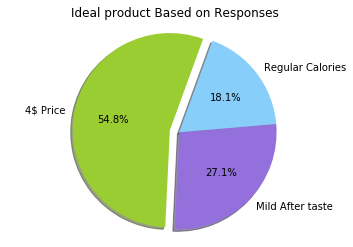

In [116]:
# Graph our winning product features

labels = '4$ Price', 'Mild After taste', 'Regular Calories'
#using values above
sizes = [54.8, 27.1, 18.1]
colors = ['yellowgreen', 'mediumpurple', 'lightskyblue'] 
explode = (0.1, 0, 0)    
plt.pie(sizes,              
        explode=explode,   
        labels=labels,      
        colors=colors,      
        autopct='%1.1f%%',  
        shadow=True,        
        startangle=70       
        )

plt.axis('equal')
plt.title('Ideal product Based on Responses')
plt.show()

## Relative importance of the product attributes
The part worth is used to derive the importance and the relative importance of an attribute of the product. Attribute importance is the difference between the highest and lowest utility level of the attribute. Relative importance of an attribute is essentially its share of importance.

If the distance between the utility levels of an attribute is large, then that attribute will have a larger bearing on the respondents choice of product than another attribute where the distance is not as large. The distance therefore is a reflection of the importance of the attribute in determining consumer preferences.

* Distance = Max(part-worth) - Min(part-worth) 
* Weight of attribute/importance = attribute distance / Sum(attribute distance)

In [97]:
#Attribute importances

price= ['$4', '$5', '$6']
Taste = ['Strong After Taste', 'Mild After Taste']
Calories = ['Full Calories', 'Regular Calories', 'Low Calories']
#function to calculate distance
def distance_cal(lista):
    newlist =[]
    for item in lista:
        x= df_res.part_worth[(df_res['feature'] == item)][0]
        newlist.append(x)
    return max(newlist) - min(newlist)
  

In [107]:
#create list of lists to be used in calculating the attribute importance and weight
attributes= [price,Taste,Calories]

#Create list attribute names
attributename = ['Price','Taste','Calories']
#Sum of attribute distance 
sum_dist = distance_cal(price) + distance_cal(Taste) + distance_cal(Calories)
i=0
#For loop to print values of distance and weight for each variable
for item in attributes : 
    print("\n Attribute : " , attributename[i])
    print ("\n Distance : " , distance_cal(item))
    print ("\n Importance %: " , distance_cal(item)/sum_dist)
    print("-----------------------")
    i=i+1



 Attribute :  Price

 Distance :  11.999999999999993

 Importance %:  0.7058823529411763
-----------------------

 Attribute :  Taste

 Distance :  3.0000000000000013

 Importance %:  0.17647058823529427
-----------------------

 Attribute :  Calories

 Distance :  1.9999999999999987

 Importance %:  0.11764705882352938
-----------------------


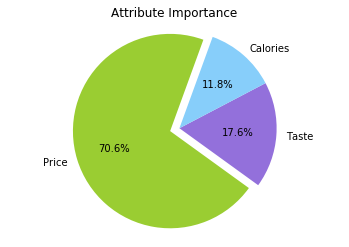

In [115]:
#Ploting the importance
sizes = [distance_cal(price)/sum_dist, distance_cal(Taste)/sum_dist, distance_cal(Calories)/sum_dist]
colors = ['yellowgreen', 'mediumpurple', 'lightskyblue'] 
explode = (0.1, 0, 0)    
plt.pie(sizes,              
        explode=explode,   
        labels=attributename,      
        colors=colors,      
        autopct='%1.1f%%',          
        startangle=70       
        )

plt.axis('equal')
plt.title('Attribute Importance')
plt.show()


## Trade off analysis
Product developers are constantly faced with trade-offs. For instance, changing the taste of the beer from a strong after taste to a mild after taste would result in an increase in price as the beer requires more additional resources. Whether this could result in an increase in demand could be determined by examining the trade-offs that consumers are willing to make.The figure below provides an illustration of attribute part-worth that is considered in the trade-off analysis. 

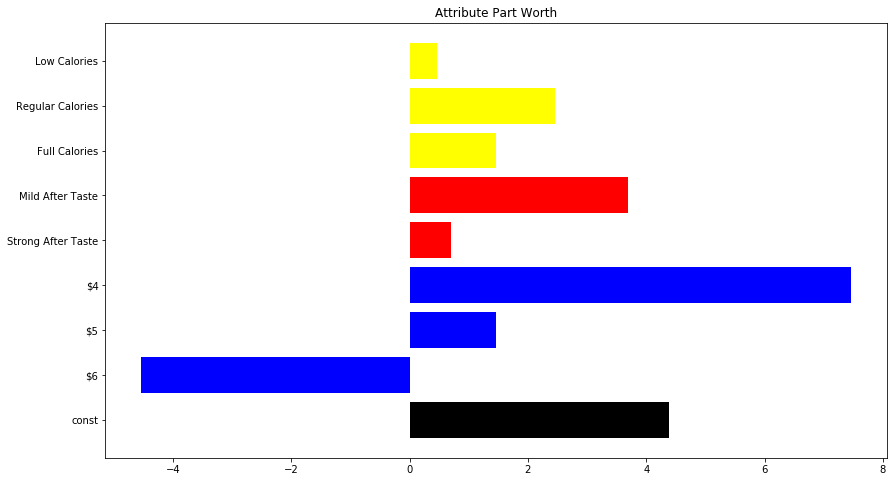

In [117]:
f, ax = plt.subplots(figsize=(14, 8))
plt.title('Attribute Part Worth')
pwu = df_res['part_worth']

xbar = np.arange(len(pwu))
my_colors = ['black','blue','blue','blue','red','red','yellow','yellow','yellow']
plt.barh(xbar, pwu,color=my_colors)
plt.yticks(xbar, labels=df_res['feature'])
plt.show()


Knowledge of the relative importance of various attributes can assist in marketing and advertising decisions. Other factors being equal, one would devote greater attention and resource to improving a product, on attributes that are of greatest importance to target consumers.

## Final Conclusion
Conjoint analysis is a marketing research technique designed to help managers determine the preferences of customers and potential customers. In particular, it seeks to determine how consumers value the different attributes that make up a product and the trade-offs they are willing to make among the different attributes or features that compose the product. As such, conjoint analysis is best suited for products that have very tangible attributes that can be easily described or quantified.

## Reference
1. Conjoint Analysis. (n.d.). Retrieved from https://www.ashokcharan.com/Marketing-Analytics/~pd-conjoint-analysis.php
2. Herka. (2020). Traditional-Conjoint-Analysis-with-Python. Retrieved from https://github.com/Herka/Traditional-Conjoint-Analysis-with-Python/blob/master/Traditional Conjoint Analyse.ipynb
3. Pratama, A. (2018, December 04). How to Do Conjoint Analysis in python. Retrieved August 5, 2020, from https://ariepratama.github.io/How-to-do-conjoint-analysis-in-python/
4. Sreenivas, P., & Follow. (2019). Conjoint Analysis: A simple python implementation. Retrieved from https://www.linkedin.com/pulse/conjoint-analysis-simple-python-implementation-prajwal-sreenivas
5. Wilcox, Ronald T., A Practical Guide to Conjoint Analysis. Darden Case No. UVA-M-0675, Available at SSRN: https://ssrn.com/abstract=910102
